In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib.pyplot as plt  # Make sure this line is included
from torch import nn, optim
import torch.nn.functional as F


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import ToPILImage


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Data Loaders
to_pil_image = ToPILImage()
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the images for ResNet
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)



Files already downloaded and verified


In [3]:
# # Encoder Definition
# class Encoder(nn.Module):
#     # Use a simple architecture; you might want to use something like ResNet for better results.
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc = nn.Linear(64*16*16, 128)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv(x)))
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return nn.functional.normalize(x, dim=1)

# q_encoder = Encoder().to(device)
# k_encoder = Encoder().to(device)
# k_encoder.load_state_dict(q_encoder.state_dict())  # Initialize k_encoder with q_encoder weights


import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc = nn.Linear(512, 128)  # Adjust the dimensions according to your need

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return nn.functional.normalize(x, dim=1)

q_encoder = Encoder().to(device)
k_encoder = Encoder().to(device)
k_encoder.load_state_dict(q_encoder.state_dict())






# Momentum Update
def momentum_update(query, key, momentum=0.999):
    for q_params, k_params in zip(query.parameters(), key.parameters()):
        k_params.data = momentum * k_params.data + (1.0 - momentum) * q_params.data

# Contrastive Loss
def contrastive_loss(q, k, queue, temperature=0.07):
    l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
    l_neg = torch.mm(q, queue.detach())

    logits = torch.cat([l_pos, l_neg], dim=1)
    logits /= temperature

    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

# Parameters and Queue Initialization
optimizer = optim.Adam(q_encoder.parameters(), lr=0.001)
queue_size = 4096
feature_dim = 128
queue = torch.randn(feature_dim, queue_size).to(device)
queue = nn.functional.normalize(queue, dim=0)
queue_ptr = 0


# Contrastive Augmentation for contrastive learning
contrastive_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor()
])



/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from torchvision.transforms.functional import to_pil_image, to_tensor
import matplotlib.pyplot as plt


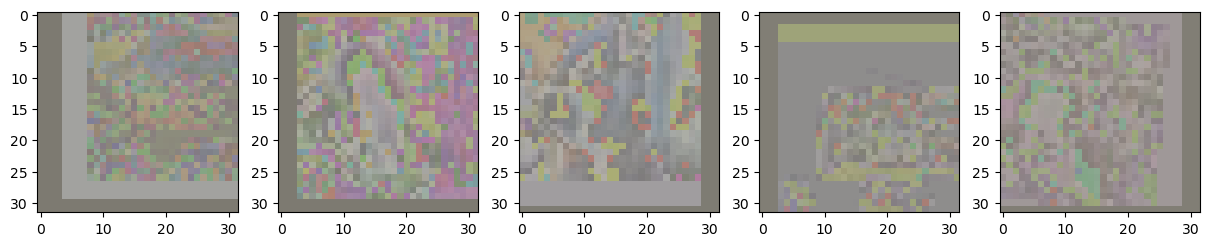

[1, 100] loss: 7.088
[1, 200] loss: 6.381
[1, 300] loss: 5.647
[2, 100] loss: 5.103
[2, 200] loss: 4.122
[2, 300] loss: 3.697
[3, 100] loss: 3.477
[3, 200] loss: 2.902
[3, 300] loss: 2.723
[4, 100] loss: 2.379
[4, 200] loss: 2.183
[4, 300] loss: 2.147
[5, 100] loss: 2.146
[5, 200] loss: 2.021
[5, 300] loss: 1.845
[6, 100] loss: 1.913
[6, 200] loss: 1.680
[6, 300] loss: 1.345
[7, 100] loss: 1.505
[7, 200] loss: 1.622
[7, 300] loss: 1.312
[8, 100] loss: 1.127
[8, 200] loss: 1.161
[8, 300] loss: 1.384
[9, 100] loss: 1.117
[9, 200] loss: 1.227
[9, 300] loss: 1.031
[10, 100] loss: 1.045
[10, 200] loss: 0.994
[10, 300] loss: 1.052
[11, 100] loss: 0.796
[11, 200] loss: 0.978
[11, 300] loss: 0.703
[12, 100] loss: 0.777
[12, 200] loss: 0.806
[12, 300] loss: 0.837
[13, 100] loss: 0.819
[13, 200] loss: 0.811
[13, 300] loss: 0.634
[14, 100] loss: 0.623
[14, 200] loss: 0.743
[14, 300] loss: 0.702
[15, 100] loss: 0.765
[15, 200] loss: 0.660
[15, 300] loss: 0.709
[16, 100] loss: 0.631
[16, 200] loss:

In [5]:
losses = []  # initialize the list outside the loop

# Training Loop
for epoch in range(50):  # Loop over the dataset multiple times
    for i, (data, _) in enumerate(trainloader, 0):
        inputs = data.to(device)

        # Convert tensor to PIL Image and apply the transform
        inputs1 = [contrastive_transform(to_pil_image(img.cpu())) for img in inputs]
        inputs1 = torch.stack(inputs1).to(device)

        inputs2 = [contrastive_transform(to_pil_image(img.cpu())) for img in inputs]
        inputs2 = torch.stack(inputs2).to(device)

        # Visualizing the transformed images
        if i == 0 and epoch == 0:  # Example to plot the first batch of the first epoch
            def denormalize(tensor):
                mean = np.array([0.4914, 0.4822, 0.4465])
                std = np.array([0.2023, 0.1994, 0.2010])
                denormalized = tensor.cpu().numpy() * std[:, None, None] + mean[:, None, None]
                denormalized = np.clip(denormalized, 0, 1)
                return denormalized

            fig, axs = plt.subplots(1, 5, figsize=(15, 5))
            for j in range(5):  # Change this value to plot more or fewer images
                image = denormalize(inputs1[j])
                axs[j].imshow(np.transpose(image, (1, 2, 0)))
            plt.show()

        q = q_encoder(inputs1)
        with torch.no_grad():
            k = k_encoder(inputs2)

        # Compute loss
        loss = contrastive_loss(q, k, queue)

        # Record the loss
        losses.append(loss.item())

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Momentum update for the key encoder
        momentum_update(q_encoder, k_encoder)

        # Update queue
        batch_size = k.size(0)
        if queue_ptr + batch_size <= queue_size:
            queue[:, queue_ptr:queue_ptr+batch_size] = k.T
        else:
            # If the batch wraps around the end of the queue
            size_before_wrap = queue_size - queue_ptr
            size_after_wrap = batch_size - size_before_wrap
            queue[:, queue_ptr:] = k.T[:, :size_before_wrap]
            queue[:, :size_after_wrap] = k.T[:, size_before_wrap:]
        queue_ptr = (queue_ptr + batch_size) % queue_size

        # Print statistics
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}")



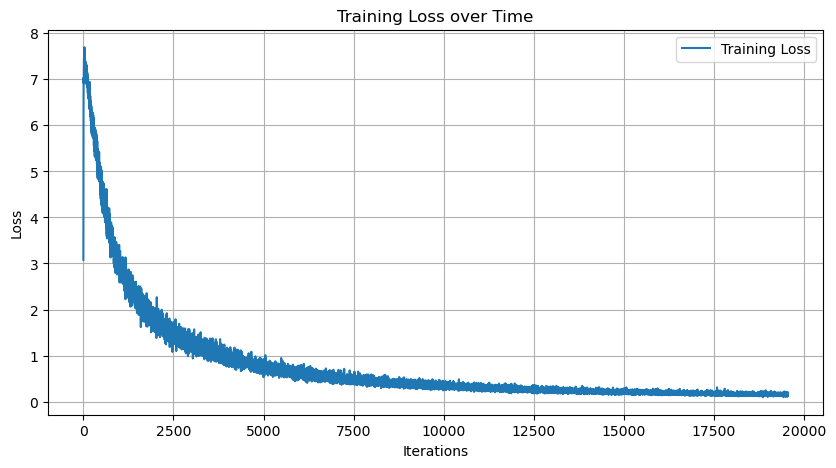

In [6]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10,5))
# plt.title("Training Loss over Time")
# plt.plot(losses)
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.show()


# Enhanced Loss Plot
plt.figure(figsize=(10, 5))
plt.title("Training Loss over Time")
plt.plot(losses, label='Training Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()



In [7]:
for param in q_encoder.parameters():
    param.requires_grad = False


# # Unfreeze some layers of the encoder for fine-tuning if required
# for param in q_encoder.conv.parameters():  # Example to unfreeze the conv layer
#     param.requires_grad = True


In [8]:
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified


In [9]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(128, num_classes)  # Assuming encoder output size is 128

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

model = Classifier(q_encoder, 100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

for epoch in range(50):
    for i, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}")




[1, 100] loss: 4.561
[1, 200] loss: 4.477
[1, 300] loss: 4.446
[2, 100] loss: 4.323
[2, 200] loss: 4.287
[2, 300] loss: 4.202
[3, 100] loss: 4.143
[3, 200] loss: 4.089
[3, 300] loss: 4.014
[4, 100] loss: 4.051
[4, 200] loss: 3.841
[4, 300] loss: 3.976
[5, 100] loss: 3.902
[5, 200] loss: 3.829
[5, 300] loss: 3.778
[6, 100] loss: 3.761
[6, 200] loss: 3.911
[6, 300] loss: 3.761
[7, 100] loss: 3.642
[7, 200] loss: 3.696
[7, 300] loss: 3.645
[8, 100] loss: 3.582
[8, 200] loss: 3.678
[8, 300] loss: 3.550
[9, 100] loss: 3.596
[9, 200] loss: 3.485
[9, 300] loss: 3.563
[10, 100] loss: 3.610
[10, 200] loss: 3.500
[10, 300] loss: 3.468
[11, 100] loss: 3.498
[11, 200] loss: 3.390
[11, 300] loss: 3.341
[12, 100] loss: 3.548
[12, 200] loss: 3.498
[12, 300] loss: 3.523
[13, 100] loss: 3.436
[13, 200] loss: 3.296
[13, 300] loss: 3.285
[14, 100] loss: 3.258
[14, 200] loss: 3.409
[14, 300] loss: 3.465
[15, 100] loss: 3.501
[15, 200] loss: 3.539
[15, 300] loss: 3.485
[16, 100] loss: 3.586
[16, 200] loss:

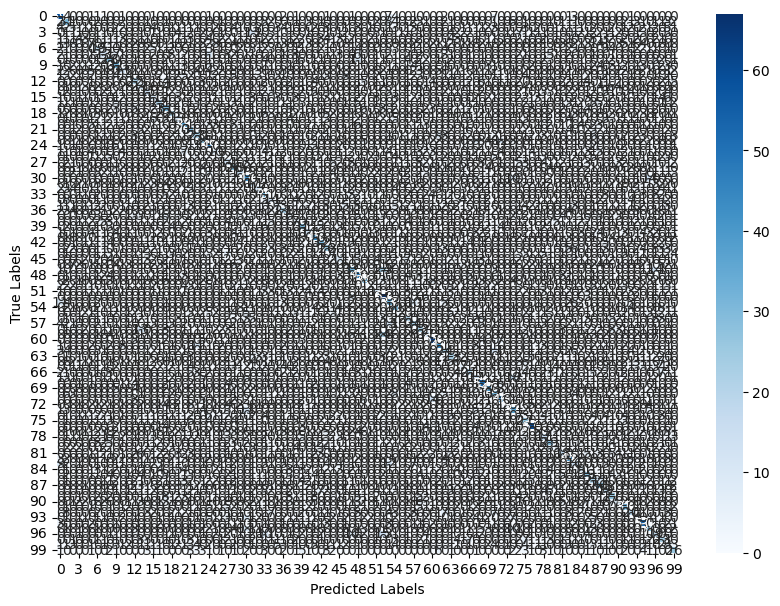

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       100
           1       0.23      0.31      0.26       100
           2       0.08      0.05      0.06       100
           3       0.02      0.01      0.01       100
           4       0.09      0.03      0.05       100
           5       0.10      0.07      0.08       100
           6       0.17      0.19      0.18       100
           7       0.15      0.13      0.14       100
           8       0.23      0.28      0.25       100
           9       0.27      0.32      0.29       100
          10       0.17      0.13      0.15       100
          11       0.17      0.04      0.06       100
          12       0.25      0.22      0.23       100
          13       0.15      0.13      0.14       100
          14       0.21      0.15      0.17       100
          15       0.11      0.11      0.11       100
          16       0.27      0.22      0.24       100
          17       0.21    

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cm = confusion_matrix(all_labels, all_predictions)

# 2. Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 3. Compute other metrics
print(classification_report(all_labels, all_predictions))        
        

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
